## ACC strength -  panan-rOM3 analysis notebook

For `8km_jra_ryf_obc_Charrassin` experiment (MOM6-CICE6 panan 1/12th degree ~ 4km with no ice shelves)

**Note** Several non-standard uses of `esm_datastore`:

- `esm_datastore` was generated with a different branch to main to pick up incorrectly named files (see https://github.com/ACCESS-NRI/access-nri-intake-catalog/issues/459, thanks to Charles Turner for fixing this for me)
- Years 9 and 10 of this run used parallelised IO, and unfortunately the tiling resulted in NaNs along part of the y axis in these files. Therefore, we must use a preprocessing function that replaces these axes with that of an earlier time (month 0) (thanks to Jemma Jeffree for her help with this!)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from dask.distributed import Client
import intake
import cmocean as cm

In [2]:
client = Client(threads_per_worker = 1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36845,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:46595,Total threads: 1
Dashboard: /proxy/40783/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:45289,


Load datastore

In [3]:
esm_datastore = intake.open_esm_datastore(
    "/g/data/ol01/cy8964/access-om3/archive/8km_jra_ryf_obc_Charrassin/experiment_datastore.json", 
    columns_with_iterables=[
            "variable",
            "variable_long_name",
            "variable_standard_name",
            "variable_cell_methods",
            "variable_units",
    ] # This is important
)

esm_datastore

,unique
filename,608
file_id,44
path,5088
filename_timestamp,131
frequency,3
start_date,240
end_date,241
variable,201
variable_long_name,183
variable_standard_name,39


List available diagnostics

In [4]:
variables = esm_datastore.unique().variable
print(variables)

['ANGLE', 'ANGLET', 'NCAT', 'VGRDa', 'VGRDb', 'VGRDi', 'VGRDs', 'aice', 'blkmask', 'congel', 'dvidtd', 'dvidtt', 'frazil', 'frzmlt', 'hi', 'hs', 'sifb', 'snoice', 'time', 'time_bounds', 'uvel', 'vvel', 'Tair_m', 'Tsfc_m', 'aice_m', 'aicen_m', 'albice_m', 'albsni_m', 'albsno_m', 'alidf_ai_m', 'alidr_ai_m', 'alvdf_ai_m', 'alvdr_ai_m', 'congel_m', 'daidtd_m', 'daidtt_m', 'divu_m', 'dvidtd_m', 'dvidtt_m', 'evap_ai_m', 'fcondtop_ai_m', 'fcondtopn_ai_m', 'fhocn_ai_m', 'flat_ai_m', 'flatn_ai_m', 'flwdn_m', 'flwup_ai_m', 'fmeltt_ai_m', 'fmelttn_ai_m', 'frazil_m', 'fresh_ai_m', 'frzmlt_m', 'fsalt_ai_m', 'fsalt_m', 'fsens_ai_m', 'fsensn_ai_m', 'fsurfn_ai_m', 'fswabs_ai_m', 'fswdn_m', 'fswthru_ai_m', 'fswup_m', 'hi_m', 'hs_m', 'ice_present_m', 'meltb_m', 'meltl_m', 'melts_m', 'meltt_m', 'opening_m', 'rain_ai_m', 'scale_factor_m', 'shear_m', 'sice_m', 'sifb_m', 'snoice_m', 'snow_ai_m', 'strairx_m', 'strairy_m', 'strcorx_m', 'strcory_m', 'strength_m', 'strintx_m', 'strinty_m', 'strocnx_m', 'strocny

Load month 0 specific datastore to get y axis info

In [5]:
mo0_esm_datastore = intake.open_esm_datastore(
    "/g/data/ol01/cy8964/access-om3/datastores/8km_jra_ryf_obc_Charrassin-output000/experiment_datastore.json", 
    columns_with_iterables=[
            "variable",
            "variable_long_name",
            "variable_standard_name",
            "variable_cell_methods",
            "variable_units",
    ] # This is important
)

ds_good_yh = mo0_esm_datastore.search(variable="umo_2d").to_dask(xarray_open_kwargs={'decode_timedelta':True})
good_yh_coords = ds_good_yh.yh.copy().load()
ds_good_yq = mo0_esm_datastore.search(variable="vmo_2d").to_dask(xarray_open_kwargs={'decode_timedelta':True})
good_yq_coords = ds_good_yq.yq.copy().load()
def reset_y_coords(ds): #thanks to Jemma Jeffree for helping make this work!!
    ds = ds.assign_coords({'yh':good_yh_coords})
    ds = ds.assign_coords({'yq':good_yq_coords})
    return ds

When loading data that has a y-axis, you need to use the `preprocess` (and likely `decode_timedelta` too) arguments:
```
esm_datastore.search(variable="").to_dask(preprocess=reset_y_coords,xarray_open_kwargs={'decode_timedelta':True})
```

For example:

### Loading other model data from the intake catalogue for comparison

Let's load in the mom6 panan01 and panan005 models, as well as ACCESS-OM2-01-RYF (potentially there is a more suitable one with more diagnostics starting from WOA but it's not on intake?)

In [8]:
catalog = intake.cat.access_nri

In [9]:
catalog.search(model="ACCESS-OM2-01", frequency="1mon",name="01deg_jra55v13_ryf9091")


,model,description,realm,frequency,variable
name,,,,,
01deg_jra55v13_ryf9091,{ACCESS-OM2-01},{0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.3 RYF9091 repeat year forcing (May 1990 to Apr 1991)},"{seaIce, ocean}",{1mon},"{evap_heat, sfc_hflux_pme, total_ocean_fprec_melt_heat, tx_trans, nv, salt, total_ocean_calving_melt_heat, pbot_t, neutral, average_DT, vicen_m, scalar_axis, hs_m, pe_tot, runoff, sw_edges_ocean, ..."


In [10]:
'''
names of panant models
panant-01-zstar-ACCESSyr2
panant-005-zstar-ACCESSyr2
panant-0025-zstar-ACCESSyr2
'''
catalog.search(name = "panant-01-zstar-ACCESSyr2")


,model,description,realm,frequency,variable
name,,,,,
panant-01-zstar-ACCESSyr2,"{SIS2, MOM6}",{0.1 degree (MOM6+SIS2) Pan-Antarctic regional model configuration under 1990-1991 JRA55-do repeat year forcing.},"{seaIce, ocean}","{1mon, fx, 1day}","{lrunoff, intz_gKEu_2d, nv, v_BT_accel, umo, geolat_u, average_DT, rho2_i, z_l_sub01, hfds, yTe, vo, taux_bot, vmo_2d, areacello_cv, intz_CAu_2d, intz_diffv_2d, so, salt_flux_added, wet_u, IX_TRAN..."


# Example: plot ACC strength as a function of time

Compare to obs: https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016GL070319

In [21]:
catalog["01deg_jra55v13_ryf9091"].search(variable ="tx_trans_int_z" , frequency="1mon").to_dask(xarray_open_kwargs={'decode_timedelta':True})


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/intake_esm/core.py:259: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


<xarray.Dataset> Size: 131GB
Dimensions:         (time: 3360, yt_ocean: 2700, xu_ocean: 3600)
Coordinates:
  * yt_ocean        (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.94 89.98
  * time            (time) object 27kB 1900-01-16 12:00:00 ... 2179-12-16 12:...
  * xu_ocean        (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.9 80.0
Data variables:
    tx_trans_int_z  (time, yt_ocean, xu_ocean) float32 131GB dask.array<chunksize=(1, 675, 900), meta=np.ndarray>
Attributes:
    filename:                        ocean_month.nc
    title:                           ACCESS-OM2-01
    grid_type:                       mosaic
    grid_tile:                       1
    intake_esm_vars:                 ['tx_trans_int_z']
    intake_esm_attrs:filename:       ocean_month.nc
    intake_esm_attrs:file_id:        ocean.1mon.nv:2.xt_ocean:3600.xu_ocean:3...
    intake_esm_attrs:frequency:      1mon
    intake_esm_attrs:realm:          ocean
    intake_esm_attrs:_data_format_:  netcdf
    intake_esm_dataset_key:          ocean.1mon.nv:2.xt_ocean:3600.xu_ocean:3...

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/intake_esm/core.py:259: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/intake_esm/core.py:259: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/intake_esm/core.py:259: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. 

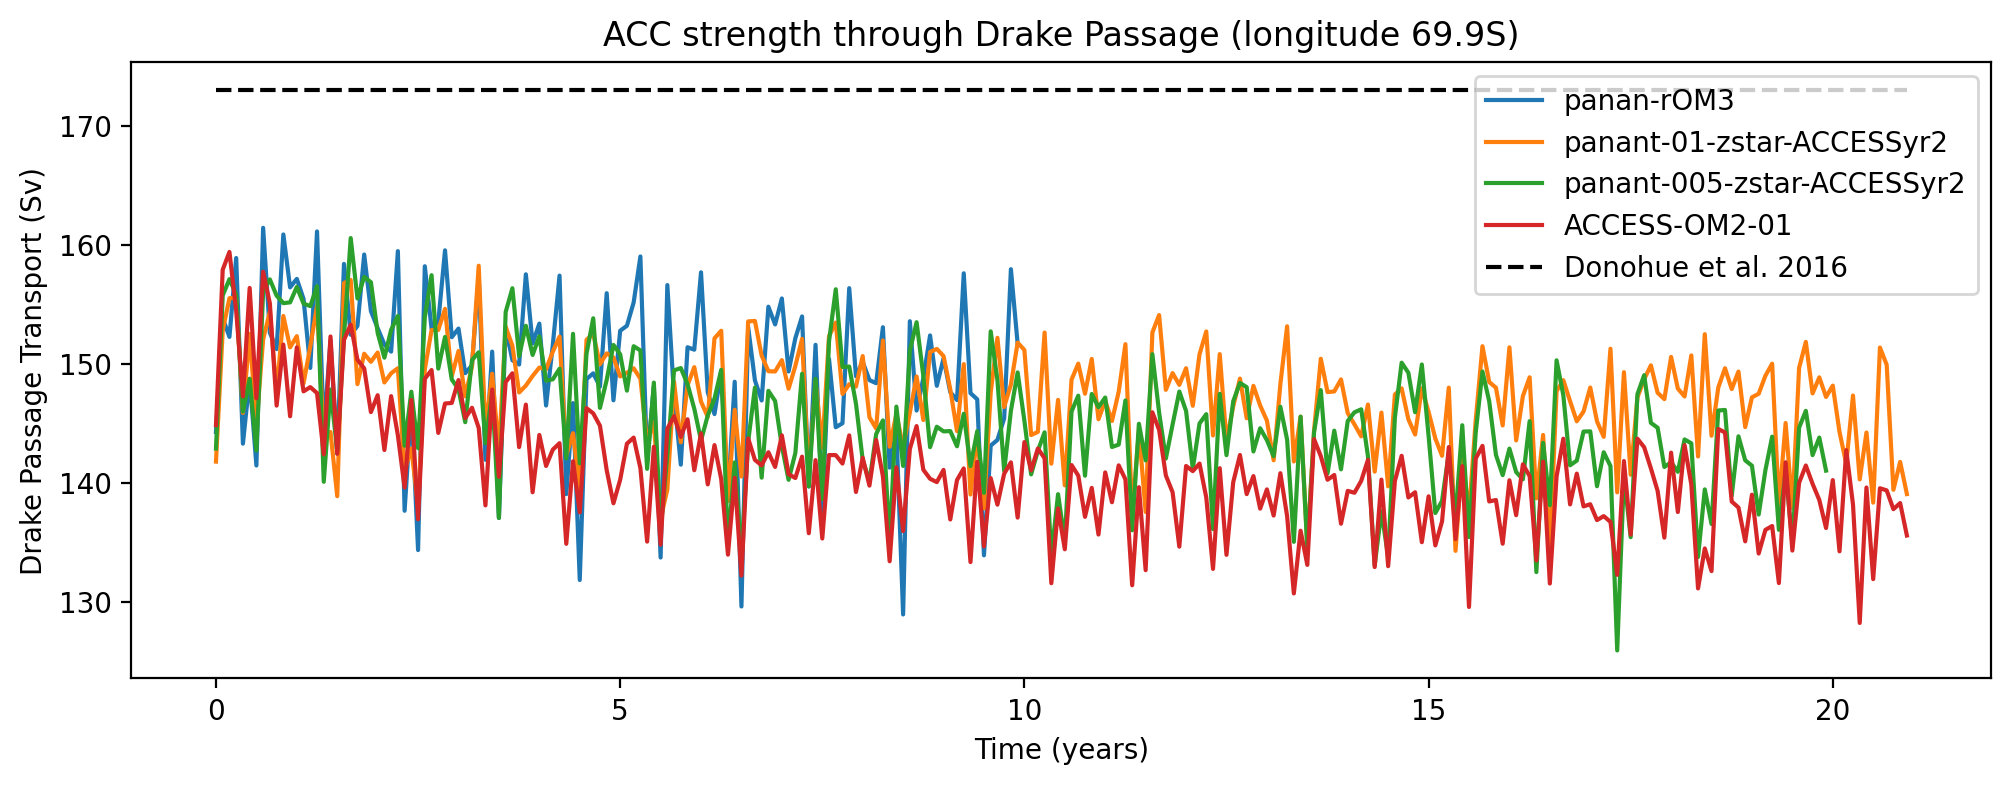

2025-08-18 17:35:19,236 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/distributed/comm/tcp.py", line 226, in read
    frames_nosplit_nbytes_bin = await stream.read_bytes(fmt_size)
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/distributed/worker.py", line 1267, in heartbeat
    response = await retry_operation(
               ^^^^^^^^^^^^^^^^^^^^^^
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/distributed/utils_comm.py", line 416, in retry_operation
    return await retry(
           ^^^^^^^^^^^^
  File "/g/d

In [22]:
#ACC transport
rho = 1035

#define figure
fig,axes = plt.subplots(figsize = (12,4),dpi = 200)

# plot new sim first
umo = esm_datastore.search(variable="umo_2d").to_dask(preprocess=reset_y_coords,xarray_open_kwargs={'decode_timedelta':True})
#drake passage transport
ACC_strength = (umo.umo_2d.sel(xq = -69.9, method = 'nearest')/1035/1e6).sum('yh')
plt.plot(np.arange(len(ACC_strength.time))/12, ACC_strength,label = 'panan-rOM3')

# plot old sims
for name in ["panant-01-zstar-ACCESSyr2","panant-005-zstar-ACCESSyr2"]:
    umo = catalog[name].search(variable="umo_2d", frequency = '1mon').to_dask(xarray_open_kwargs={'decode_timedelta':True})
    ACC_strength = (umo.umo_2d.sel(xq = -69.9, method = 'nearest')/1035/1e6).sum('yh')
    plt.plot(np.arange(len(ACC_strength.time))/12, ACC_strength,label = name)

tx_trans_int_z = catalog["01deg_jra55v13_ryf9091"].search(variable ="tx_trans_int_z" , frequency="1mon").to_dask(xarray_open_kwargs={'decode_timedelta':True})
tx_trans_int_z = tx_trans_int_z.sel(time = slice('1900-01-01','1920-12-31'))
ACC_strength = (tx_trans_int_z.tx_trans_int_z.sel(xu_ocean = -69.9, method = 'nearest')/1035/1e6).sum('yt_ocean')
plt.plot(np.arange(len(ACC_strength.time))/12, ACC_strength,label = 'ACCESS-OM2-01')

plt.plot([(np.arange(len(ACC_strength.time))/12)[0],(np.arange(len(ACC_strength.time))/12)[-1]],
         [173,173],'k--',label = 'Donohue et al. 2016')
plt.title('ACC strength through Drake Passage (longitude 69.9S)')
plt.ylabel('Drake Passage Transport (Sv)')
plt.xlabel('Time (years)')
plt.legend()